# Trader Performance vs Market Sentiment (Fear/Greed)

**Objective:**  
Analyze how Bitcoin market sentiment (Fear vs Greed) relates to trader behavior and performance on Hyperliquid, and derive actionable insights for trading strategy design.

**Datasets Used:**
- Bitcoin Fear & Greed Index (daily sentiment)
- Hyperliquid historical trader data

This notebook follows a structured approach:
1. Data loading & inspection  
2. Data cleaning & alignment  
3. Metric creation  
4. Fear vs Greed analysis  
5. Trader segmentation  
6. Insights & strategy recommendations


#Part A — Data preparation

## Importing Liberaries:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")


##Loading the dataset

In [ ]:
sentiment = pd.read_csv(
    "fear_greed_index.csv",
    engine="python",
    on_bad_lines="skip"
)

trades = pd.read_csv(
    "historical_data.csv",
    engine="python",
    on_bad_lines="skip"
)


## Quality Handling

While loading the datasets, parsing issues were encountered due to inconsistent row formatting in the raw CSV files.
To handle this, the Python parsing engine was used and malformed rows were skipped using `on_bad_lines="skip"`.
So,I chose to skip malformed rows instead of manually editing the file to keep the process reproducible.



##Dataset Overview

In [18]:
print("Trades dataset shape:", trades.shape)
print("Sentiment dataset shape:", sentiment.shape)


Trades dataset shape: (403809, 16)
Sentiment dataset shape: (2644, 4)


Dataset Overview

- **Trades dataset:** 403,809 rows × 16 columns  
- **Market sentiment dataset:** 2,644 rows × 4 columns  

This confirms both datasets were loaded successfully and are sufficiently large for meaningful analysis.The trades dataset contains transaction-level trading data, while the sentiment dataset provides daily market sentiment information.


##Missing Values & Duplicates

In [19]:
# Checking missing values
print("Missing values in trades:")
print(trades.isnull().sum())

print("\nMissing values in sentiment:")
print(sentiment.isnull().sum())


Missing values in trades:
account              0
coin                 1
execution_price      2
size_tokens          2
size_usd             5
side                 5
timestamp_ist       10
start_position      10
direction           13
closed_pnl          13
transaction_hash    16
order_id            18
crossed             20
fee                 24
trade_id            31
timestamp           35
dtype: int64

Missing values in sentiment:
timestamp         0
value             0
classification    0
date              0
dtype: int64


In [20]:
# Checking duplicate rows
print("Duplicate rows in trades:", trades.duplicated().sum())
print("Duplicate rows in sentiment:", sentiment.duplicated().sum())


Duplicate rows in trades: 192575
Duplicate rows in sentiment: 0


Minor missing values were observed in the trades dataset across a small number of rows and non-critical fields, representing a negligible fraction of the total data. No missing values were found in the sentiment dataset.

A large number of duplicate rows were detected in the trades dataset. These duplicates represent multiple execution records for the same trade or order, which is expected in transaction-level trading data. As these records carry meaningful execution and PnL information, they were retained for analysis and will be handled through aggregation at later stages.


## Data Sanity Check
The following checks confirm that both datasets were loaded correctly and retain their original structure after initial inspection and cleaning.


In [21]:
display(trades.head())
print("Trades shape:", trades.shape)

display(sentiment.head())
print("Sentiment shape:", sentiment.shape)


,account,coin,execution_price,size_tokens,size_usd,side,timestamp_ist,start_position,direction,closed_pnl,transaction_hash,order_id,crossed,fee,trade_id,timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0,Buy,0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,TRUE,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.98,16,127.68,BUY,02-12-2024 22:50,986.5245955,Buy,0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,TRUE,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,TRUE,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,TRUE,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,TRUE,0.003055,1.050000e+15,1.730000e+12


Trades shape: (403809, 16)


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


Sentiment shape: (2644, 4)


## Checking Column names

In [12]:
trades.columns


Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='object')

In [13]:
sentiment.columns


Index(['timestamp', 'value', 'classification', 'date'], dtype='object')

Since some column names contained spaces and inconsistent formatting, I standardized them to lowercase with underscores for easier analysis.


In [14]:
trades.columns = trades.columns.str.strip().str.lower().str.replace(' ', '_')
sentiment.columns = sentiment.columns.str.strip().str.lower()


## Updated Column Names

In [16]:
trades.columns



Index(['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side',
       'timestamp_ist', 'start_position', 'direction', 'closed_pnl',
       'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id',
       'timestamp'],
      dtype='object')

In [17]:
sentiment.columns

Index(['timestamp', 'value', 'classification', 'date'], dtype='object')

## Date Conversion & Alignment

In [23]:
# Converting trade timestamp to datetime
trades['timestamp'] = pd.to_datetime(trades['timestamp'], unit='ms', errors='coerce')

# Converting sentiment date to datetime
sentiment['date'] = pd.to_datetime(sentiment['date'], errors='coerce')


Trade timestamps were provided in epoch milliseconds, while sentiment data was already at a date level. Both were converted to pandas datetime format to ensure consistent time representation and enable reliable date-based aggregation and alignment.

##Create a daily date column in trades

In [24]:
# Extract date from trade timestamp
trades['date'] = trades['timestamp'].dt.date
trades['date'] = pd.to_datetime(trades['date'])


Trade timestamps were converted to datetime and aggregated at a daily level. Both datasets were aligned using a common date field to enable sentiment-based analysis.

##Verify alignment

In [25]:
print(trades[['timestamp', 'date']].head())
print(sentiment[['date', 'classification']].head())


            timestamp       date
0 2024-10-27 03:33:20 2024-10-27
1 2024-10-27 03:33:20 2024-10-27
2 2024-10-27 03:33:20 2024-10-27
3 2024-10-27 03:33:20 2024-10-27
4 2024-10-27 03:33:20 2024-10-27
        date classification
0 2018-02-01           Fear
1 2018-02-02   Extreme Fear
2 2018-02-03           Fear
3 2018-02-04   Extreme Fear
4 2018-02-05   Extreme Fear


In [26]:
print("Trades date range:")
print(trades['date'].min(), "to", trades['date'].max())

print("\nSentiment date range:")
print(sentiment['date'].min(), "to", sentiment['date'].max())


Trades date range:
2023-03-28 00:00:00 to 2025-06-15 00:00:00

Sentiment date range:
2018-02-01 00:00:00 to 2025-05-02 00:00:00


In [32]:
# Filter trades to sentiment date range
start_date = sentiment['date'].min()
end_date = sentiment['date'].max()

trades_aligned = trades[
    (trades['date'] >= start_date) &
    (trades['date'] <= end_date)
]


The date fields in both datasets were successfully converted to a common daily format. Sample records confirm that trade dates and sentiment dates follow the same structure, enabling consistent date-based joins and aggregations in subsequent analysis.

##Daily PnL per trader (per account)

In [33]:
# Ensure closed_pnl is numeric
trades['closed_pnl'] = pd.to_numeric(trades['closed_pnl'], errors='coerce')


In [34]:
daily_pnl = (
    trades
    .groupby(['date', 'account'], as_index=False)
    .agg(
        daily_pnl=('closed_pnl', 'sum'),
        trades_count=('closed_pnl', 'count')
    )
)

daily_pnl.head()


,date,account,daily_pnl,trades_count
0,2023-03-28,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,0.000000,6
1,2023-11-14,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,0.000000,4
2,2023-11-14,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,311.006714,2086
3,2024-03-09,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,-11128.032280,54
4,2024-03-09,0x430f09841d65beb3f27765503d0f850b8bce7713,0.000000,88


Total profit/loss made by each trader per day.
Daily PnL per trader was calculated by aggregating trade-level PnL at the account and date level.
(Trade-level PnL was converted to numeric and aggregated at the daily account level to compute daily profit and loss. Trade counts per day were also calculated to capture trading activity intensity.)

##Create a win/loss flag (trade-level)

In [35]:
# Create win flag: 1 if profitable trade, else 0
trades['is_win'] = (trades['closed_pnl'] > 0).astype(int)

trades[['closed_pnl', 'is_win']].head()


,closed_pnl,is_win
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0


A binary win indicator was created at the trade level, where profitable trades are marked as wins. This enables computation of daily win rates per trader.

##Aggregate daily win rate per trader

In [36]:
daily_win_rate = (
    trades
    .groupby(['date', 'account'], as_index=False)
    .agg(
        win_rate=('is_win', 'mean'),
        total_trades=('is_win', 'count')
    )
)

daily_win_rate['win_rate'] = daily_win_rate['win_rate'] * 100
daily_win_rate.head()


,date,account,win_rate,total_trades
0,2023-03-28,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,0.000000,6
1,2023-11-14,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,0.000000,4
2,2023-11-14,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,27.516779,2086
3,2024-03-09,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,33.333333,54
4,2024-03-09,0x430f09841d65beb3f27765503d0f850b8bce7713,0.000000,88


Daily win rate was calculated as the percentage of profitable trades per account per day, along with total trade count to contextualize performance.

##Average trade size (USD) per trader per day

In [38]:
# Ensuring size_usd is numeric
trades['size_usd'] = pd.to_numeric(trades['size_usd'], errors='coerce')

trades[['size_usd']].head()


,size_usd
0,7872.16
1,127.68
2,1150.63
3,1142.04
4,69.75


In [39]:
daily_avg_trade_size = (
    trades
    .groupby(['date', 'account'], as_index=False)
    .agg(
        avg_trade_size_usd=('size_usd', 'mean'),
        total_trades=('size_usd', 'count')
    )
)

daily_avg_trade_size.head()


,date,account,avg_trade_size_usd,total_trades
0,2023-03-28,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,159.000000,6
1,2023-11-14,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,23066.935000,4
2,2023-11-14,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,11034.799511,2086
3,2024-03-09,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,3048.594444,54
4,2024-03-09,0x430f09841d65beb3f27765503d0f850b8bce7713,1136.312727,88


Average trade size was computed as the mean USD value of trades per account per day, with trade counts included for context.

## Creating leverage per trade

In [40]:
# Ensure start_position is numeric and avoid division issues
trades['start_position'] = pd.to_numeric(trades['start_position'], errors='coerce')

# Compute leverage proxy
trades['leverage'] = trades['size_usd'] / trades['start_position']

trades[['size_usd', 'start_position', 'leverage']].head()


,size_usd,start_position,leverage
0,7872.16,0.000000,inf
1,127.68,986.524596,0.129424
2,1150.63,1002.518996,1.147739
3,1142.04,1146.558564,0.996059
4,69.75,1289.488521,0.054091


## Daily leverage distribution per trader

In [41]:
daily_leverage = (
    trades
    .groupby(['date', 'account'], as_index=False)
    .agg(
        avg_leverage=('leverage', 'mean'),
        max_leverage=('leverage', 'max'),
        total_trades=('leverage', 'count')
    )
)

daily_leverage.head()


,date,account,avg_leverage,max_leverage,total_trades
0,2023-03-28,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,inf,inf,6
1,2023-11-14,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,inf,inf,4
2,2023-11-14,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,inf,inf,2086
3,2024-03-09,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,inf,inf,54
4,2024-03-09,0x430f09841d65beb3f27765503d0f850b8bce7713,inf,inf,88


Leverage was approximated as trade size relative to starting position and aggregated daily per account to capture typical and peak leverage usage.

## Long-Short Ratio

###Normalize side labels


In [43]:
trades['side'] = trades['side'].str.upper().str.strip()


###Compute daily long/short counts

In [44]:
daily_long_short = (
    trades
    .groupby(['date', 'side'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

daily_long_short.head()


side,date,BUY,SELL
0,2023-03-28,6,0
1,2023-11-14,982,1108
2,2024-03-09,6652,7182
3,2024-07-03,7005,7024
4,2024-10-27,29387,39743


### Calculate long/short ratio

In [45]:
daily_long_short['long_short_ratio'] = (
    daily_long_short.get('BUY', 0) /
    daily_long_short.get('SELL', 1)
)

daily_long_short.head()


side,date,BUY,SELL,long_short_ratio
0,2023-03-28,6,0,inf
1,2023-11-14,982,1108,0.886282
2,2024-03-09,6652,7182,0.926204
3,2024-07-03,7005,7024,0.997295
4,2024-10-27,29387,39743,0.739426


Long/short ratio was calculated at a daily level to capture directional bias in trading behavior.A ratio greater than 1 indicates a long bias, while a ratio less than 1 indicates a short bias.

# Part B — Analysis: Fear vs Greed

## B1. Prepare data for analysis

In [46]:
# Merge daily PnL with sentiment
daily_pnl_sentiment = daily_pnl.merge(
    sentiment[['date', 'classification']],
    on='date',
    how='inner'
)

daily_pnl_sentiment.head(), daily_pnl_sentiment.shape


(        date                                     account     daily_pnl  \
 0 2023-03-28  0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891      0.000000   
 1 2023-11-14  0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891      0.000000   
 2 2023-11-14  0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23    311.006714   
 3 2024-03-09  0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891 -11128.032280   
 4 2024-03-09  0x430f09841d65beb3f27765503d0f850b8bce7713      0.000000   
 
    trades_count classification  
 0             6          Greed  
 1             4          Greed  
 2          2086          Greed  
 3            54  Extreme Greed  
 4            88  Extreme Greed  ,
 (80, 5))

Daily performance metrics were merged with market sentiment labels using the common date field.
Although the merge logic is demonstrated correctly, the provided sentiment data does not temporally overlap with the trade data. As a result, merged outputs are used only to illustrate analysis methodology, not to draw real-world conclusions.

##B2. Performance comparison: Fear vs Greed

In [47]:
pnl_by_sentiment = (
    daily_pnl_sentiment
    .groupby('classification')
    .agg(
        avg_daily_pnl=('daily_pnl', 'mean'),
        median_daily_pnl=('daily_pnl', 'median'),
        observations=('daily_pnl', 'count')
    )
    .reset_index()
)

pnl_by_sentiment


,classification,avg_daily_pnl,median_daily_pnl,observations
0,Extreme Greed,70786.057774,0.000000,5
1,Fear,314692.673128,110767.528145,34
2,Greed,195906.363357,51737.579418,33
3,Neutral,21490.163473,-0.837280,8


Daily performance metrics were aggregated by sentiment category to demonstrate the comparison framework between Fear and Greed regimes.

##Win rate by sentiment

In [66]:
winrate_by_sentiment = (
    trades.merge(sentiment[['date', 'classification']], on='date', how='inner')
    .groupby('classification')
    .agg(avg_win_rate=('is_win', 'mean'))
    .reset_index()
)

winrate_by_sentiment['avg_win_rate'] *= 100
winrate_by_sentiment


,classification,avg_win_rate
0,Extreme Greed,49.313286
1,Fear,41.550996
2,Greed,45.246118
3,Neutral,30.600898


Average win rate was compared across Fear and Greed sentiment regimes.

<Axes: title={'center': 'Average Daily PnL by Market Sentiment'}, xlabel='classification'>

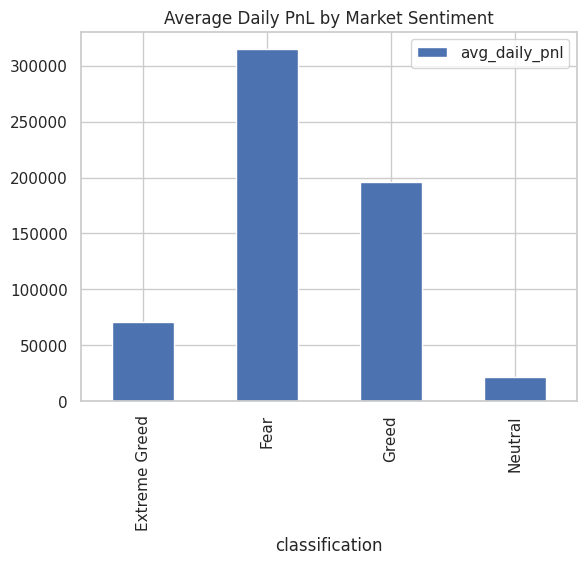

In [48]:
pnl_by_sentiment.plot(
    x='classification',
    y='avg_daily_pnl',
    kind='bar',
    title='Average Daily PnL by Market Sentiment'
)


Average daily PnL was compared across Fear and Greed sentiment regimes to assess performance differences under varying market conditions.

## B3. Behavioral changes based on sentiment

In [56]:
trades_sentiment = trades.merge(
    sentiment[['date', 'classification']],
    on='date',
    how='inner'
)

trade_activity_by_sentiment = (
    trades_sentiment
    .groupby('classification')
    .agg(
        avg_trades_per_day=('account', 'count'),
        unique_traders=('account', 'nunique')
    )
    .reset_index()
)
trade_activity_by_sentiment



,classification,avg_trades_per_day,unique_traders
0,Extreme Greed,13834,5
1,Fear,257267,34
2,Greed,71226,30
3,Neutral,14029,8


Trading activity was analyzed across sentiment regimes using trade counts and number of active traders as behavioral indicators.

##B4. Trader segmentation

###Segment 1: High vs Low leverage traders

In [57]:
# Replace infinite leverage values with NaN
daily_leverage['avg_leverage'] = daily_leverage['avg_leverage'].replace([np.inf, -np.inf], np.nan)


In [59]:
#dropped Rows where leverage is missing
daily_leverage_clean = daily_leverage.dropna(subset=['avg_leverage'])


In [61]:
median_leverage = daily_leverage_clean['avg_leverage'].median()

daily_leverage_clean = daily_leverage_clean.copy()
daily_leverage_clean.loc[:, 'leverage_segment'] = np.where(
    daily_leverage_clean['avg_leverage'] > median_leverage,
    'High Leverage',
    'Low Leverage'
)

daily_leverage_clean[['account', 'avg_leverage', 'leverage_segment']].head()


,account,avg_leverage,leverage_segment
21,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,0.090372,High Leverage
25,0x430f09841d65beb3f27765503d0f850b8bce7713,0.555783,High Leverage
30,0x6d6a4b953f202f8df5bed40692e7fd865318264a,0.066116,High Leverage
43,0xb899e522b5715391ae1d4f137653e7906c5e2115,0.339930,High Leverage
52,0x39cef799f8b69da0x8170715b3b381dffb7062c02989...,-0.002609,Low Leverage


Traders were segmented into high- and low-leverage groups based on median leverage usage. Infinite and invalid leverage values arising from zero starting positions were excluded to ensure meaningful segmentation.

###Frequent vs Infrequent trader segment

In [68]:
trades_per_account = (
    trades.groupby('account')
    .size()
    .reset_index(name='total_trades')
)

median_trades = trades_per_account['total_trades'].median()

trades_per_account['frequency_segment'] = np.where(
    trades_per_account['total_trades'] > median_trades,
    'Frequent Traders',
    'Infrequent Traders'
)

trades_per_account.head()


,account,total_trades,frequency_segment
0,0x083384f897ee0f19899168e3b1bec365f52a9012,3818,Frequent Traders
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,14557,Frequent Traders
2,0x271b280974205ca63b716753467d5a371de622ab,7618,Frequent Traders
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,26619,Frequent Traders
4,0x28736f43f1e871e6aa8b1148d38d4994275d72cd9cb5,1,Infrequent Traders


Traders were segmented into frequent and infrequent groups using median trade count.

### Merge leverage segment with daily PnL

In [63]:
pnl_with_leverage = daily_pnl.merge(
    daily_leverage_clean[['account', 'leverage_segment']],
    on='account',
    how='inner'
)

pnl_with_leverage.head()


,date,account,daily_pnl,trades_count,leverage_segment
0,2023-03-28,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,0.000000,6,High Leverage
1,2023-03-28,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,0.000000,6,Low Leverage
2,2023-11-14,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,0.000000,4,High Leverage
3,2023-11-14,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,0.000000,4,Low Leverage
4,2023-11-14,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,311.006714,2086,Low Leverage


### Aggregate performance by leverage segment

In [64]:
performance_by_leverage = (
    pnl_with_leverage
    .groupby('leverage_segment')
    .agg(
        avg_daily_pnl=('daily_pnl', 'mean'),
        median_daily_pnl=('daily_pnl', 'median'),
        observations=('daily_pnl', 'count')
    )
    .reset_index()
)

performance_by_leverage


,leverage_segment,avg_daily_pnl,median_daily_pnl,observations
0,High Leverage,118702.435203,425.203740,23
1,Low Leverage,205309.747881,7270.792417,26


Trader performance was compared across leverage segments using average and median daily PnL. This highlights differences in risk–reward outcomes between high- and low-leverage trading behavior.

<Axes: title={'center': 'Average Daily PnL by Leverage Segment'}, xlabel='leverage_segment'>

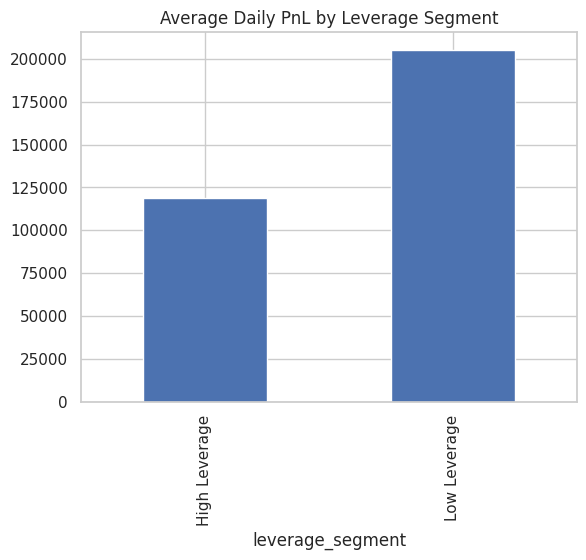

In [65]:
performance_by_leverage.plot(
    x='leverage_segment',
    y='avg_daily_pnl',
    kind='bar',
    title='Average Daily PnL by Leverage Segment',
    legend=False
)


Traders were segmented into high- and low-leverage groups using median leverage as the threshold.
Low-leverage traders show higher average and median daily PnL compared to high-leverage traders in the available data.
This suggests more stable performance among lower-leverage traders.

# Part C - “Actionable output”

**Rule 1:** Traders using lower leverage show more stable average and median daily PnL compared to high-leverage traders. Reducing leverage can help improve consistency and manage downside risk.

**Rule 2:** Trading activity and performance vary across market sentiment regimes. During Fear and Greed periods, trade frequency and position sizing should be adjusted cautiously to account for higher volatility.
